In [46]:
# Importing the necessary libraries
import tensorflow as tf
import json
import os
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [47]:
# Necessary Variables
vocab_size = 3000
embedding_dim = 32
max_length = 60
truncation_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [48]:
dataList = []
sentences = []
labels = []
# Stopwords should be removed or excluded from the given text so that more 
# focus can be given to those words which define the meaning of the text.
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  d=[]
  with open(filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    for word in stopwords: #Remove stop words in sentence
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    d.append([sentence,label])
  return d
# Loading both sensitive and non-sensitive dataset
sen=loadDataset("SensitiveDataset.json")
nonsen=loadDataset("NonSensitiveDatasetnew.json")

import pandas as pd
sen=pd.DataFrame(data=sen,columns=['sentences','labels'])
nonsen=pd.DataFrame(data=nonsen,columns=['sentences','labels'])
print(sen['labels'].value_counts(),nonsen['labels'].value_counts())


labels
1    15576
Name: count, dtype: int64 labels
0    16000
Name: count, dtype: int64


In [49]:
# Assuming df1 and df2 are your two dataframes
df= pd.concat([sen, nonsen], axis=0)  # Concatenate along rows (axis=0)
df.head(5)

,sentences,labels
0,"username:aaliyah, password:123456, email:aaliy...",1
1,"username:aaren, password:12345, email:aaren@ya...",1
2,"username:aarika, password:123456789, email:aar...",1
3,"username:aaron, password:iloveyou, email:aaron...",1
4,"username:aartjan, password:princess, email:aar...",1


In [50]:
df=df.sample(frac=1).reset_index(drop=True)
df.head(5)

,sentences,labels
0,"username:deandre, password:dalejr, email:deand...",1
1,"full name:govinthan govindammal, father's nam...",1
2,"username:chocs, password:smelly, email:chocs@l...",1
3,Ohio girl Marilyn Miller ends joining vaudevil...,0
4,"full name:mahender kumar, father's name:kumar...",1


In [51]:
df_sen=df[df['labels']==1]
df_sen.shape

(15576, 2)

In [52]:
df_non=df[df['labels']==0]
df_non.shape

(16000, 2)

In [53]:
df_non_downsampled = df_non.sample(df_sen.shape[0])
df_non_downsampled.shape

(15576, 2)

In [54]:
df_balanced = pd.concat([df_non_downsampled, df_sen])
df_balanced.shape

(31152, 2)

In [55]:
df_balanced['labels'].value_counts()

labels
0    15576
1    15576
Name: count, dtype: int64

In [56]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df_balanced['sentences'],df_balanced['labels'],stratify=df_balanced['labels'])
X_train.head(4)

20429    username:dena, password:bluesky, email:dena@ar...
11507    After saving New York City demi-god Gozer, Gho...
9000     full name:som  dutt, father's name:dutt, date ...
9798     After bandit El Gavilan men blow South America...
Name: sentences, dtype: object

In [57]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [58]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

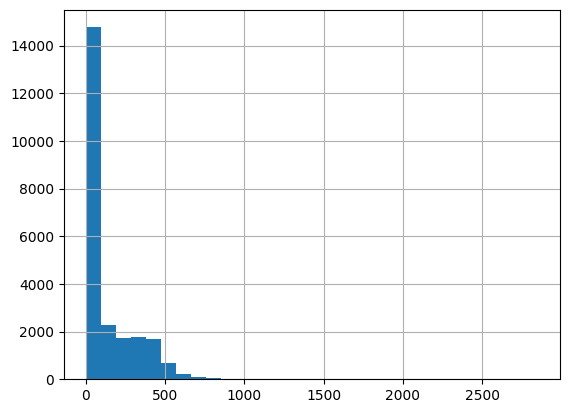

In [59]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)

In [60]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print("Size of word index:", len(word_index))

with open("word_index.json", "w") as outfile:  
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

#create attention masks for training and validation
attention_masks = []
for seq in training_padded:
  seq_mask = [int(i>0) for i in seq]
  attention_masks.append(seq_mask)

attention_masks_val = []
for seq in validation_padded:
  seq_mask = [int(i>0) for i in seq]
  attention_masks_val.append(seq_mask)


Size of word index: 111939
Saving the word index as JSON


In [61]:
train_seq = torch.tensor(training_padded.tolist())
train_mask = torch.tensor(attention_masks)
train_y = torch.tensor(y_train.tolist())

test_seq = torch.tensor(validation_padded.tolist())
test_mask = torch.tensor(attention_masks_val)
test_y = torch.tensor(y_test.tolist())

In [62]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 32
# wrap tensors
train_data = TensorDataset(train_seq,train_mask,train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(test_seq,test_mask,test_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [63]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [64]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()      
        self.bert = bert 
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        # relu activation function
        self.relu =  nn.ReLU()
        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):    
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)
        return x

In [79]:
#build a tensor model
model = BERT_Arch(bert)

In [81]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# Move the model to the device
model = model.to(device)

In [82]:
class_weights = [1.0, 1.0]

# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [84]:
# set initial loss to infinite
best_valid_loss = float('inf')

#defining epochs
epochs = 1

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
#for each epoch
for epoch in range(epochs):   
    # function to train the model
    def train():
        model.train()
        total_loss, total_accuracy = 0, 0
        # empty list to save model predictions
        total_preds=[]
        # iterate over batches
        for step,batch in enumerate(train_dataloader):
            # progress update after every 50 batches.
            if step % 50 == 0 and not step == 0:
                print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
            # push the batch to gpu
            batch = [torch.tensor(r).to(device) for r in batch]
            sent_id, mask, labels = batch
            # clear previously calculated gradients 
            model.zero_grad()        
            # get model predictions for the current batch
            preds = model(sent_id, mask)
            # compute the loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            # add on to the total loss
            total_loss = total_loss + loss.item()
            # backward pass to calculate the gradients
            loss.backward()
            # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            #defining optimizer
            optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)
            # update parameters
            optimizer.step()
            # model predictions are stored on GPU. So, push it to CPU
            preds=preds.detach().cpu().numpy()
            # append the model predictions
            total_preds.append(preds)
        # compute the training loss of the epoch
        avg_loss = total_loss / len(train_dataloader)
        # predictions are in the form of (no. of batches, size of batch, no. of classes).
        # reshape the predictions in form of (number of samples, no. of classes)
        total_preds  = np.concatenate(total_preds, axis=0)
        # returns the average loss and total predictions
        return avg_loss, total_preds


In [85]:
# function for evaluating the model
def evaluate():   
    print("\nEvaluating...")
    # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy = 0, 0
    # empty list to save the model predictions
    total_preds = []
    # iterate over batches
    for step,batch in enumerate(validation_padded):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            #elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        # push the batch to gpu
        batch = [torch.tensor(r).to(device) for r in batch]
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

In [87]:
# set initial loss to infinite
best_valid_loss = float('inf')
#defining epochs
epochs = 1
# empty lists to store training and validation loss of each epoch
train_losses=[]
#for each epoch
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss,_ = train()
    # append training and validation loss
    train_losses.append(train_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 1


C:\Users\LAKSHMI SRI LASYA\AppData\Local\Temp\ipykernel_3080\3441229909.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(r).to(device) for r in batch]


  Batch    50  of    731.
  Batch   100  of    731.
  Batch   150  of    731.
  Batch   200  of    731.
  Batch   250  of    731.
  Batch   300  of    731.
  Batch   350  of    731.
  Batch   400  of    731.
  Batch   450  of    731.
  Batch   500  of    731.
  Batch   550  of    731.
  Batch   600  of    731.
  Batch   650  of    731.
  Batch   700  of    731.

Training Loss: 0.334


In [ ]:
#evaluate model
valid_losses=[]
valid_loss,_ = evaluate()
#save the best model
if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved_weights.pt')
valid_losses.append(valid_loss)
print(f'Validation Loss: {valid_loss:.3f}')


In [89]:
from sklearn.metrics import classification_report
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()


# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3894
           1       0.90      0.86      0.88      3894

    accuracy                           0.89      7788
   macro avg       0.89      0.89      0.89      7788
weighted avg       0.89      0.89      0.89      7788

